In [3]:
from deeplab3.dataloaders import make_dataset
from deeplab3.dataloaders import custom_transforms as tr
from deeplab3.dataloaders.utils import decode_segmap
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import torch

import json
import datetime

from deeplab3.utils import model_utils

Visualize Darkening Effect
----

In [4]:
from deeplab3.config.defaults import get_cfg_defaults
cfg = get_cfg_defaults()
cfg.merge_from_file('../configs/cityscapes_rgbd.yaml')
cfg.merge_from_list(['DATASET.ROOT', '../datasets/cityscapes/'])

Text(0.5, 1.0, 'Original')

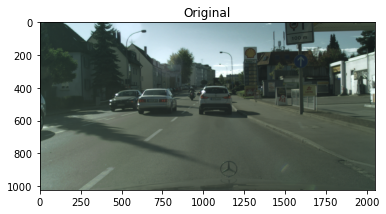

In [6]:
dataset = make_dataset(cfg, 'val')
img_path, depth_path, label_path = dataset.get_path(2)
sample = dataset.loader.get_sample(img_path, depth_path, label_path)
image = sample['image']

plt.figure()
plt.imshow(image)
plt.title("Original")

### Different Darkening Degrees

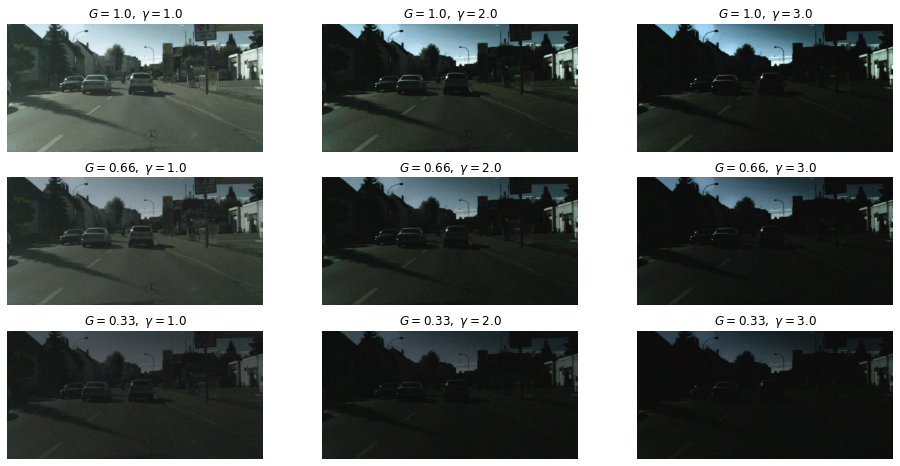

In [7]:
gain = [1.0, 0.66, 0.33]
gamma = [1.0, 2.0, 3.0]

plt.figure(figsize=(16, 8))

index = 1
for i in gain:
    for j in gamma:
        sample['image'] = image.copy()
        
        cfg = get_cfg_defaults()
        cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                            'DATASET.DARKEN.GAIN', float(i),
                            'DATASET.DARKEN.GAMMA', float(j)])
        f = tr.Darken(cfg)
        processed_sample = f(sample)
        
        plt.subplot(len(gain), len(gamma), index)
        plt.imshow(processed_sample['image'])
        plt.title("$G = {},~\gamma = {}$".format(i, j))
        plt.axis('off')
        
        index += 1

### RE-Brightened to visualize noise

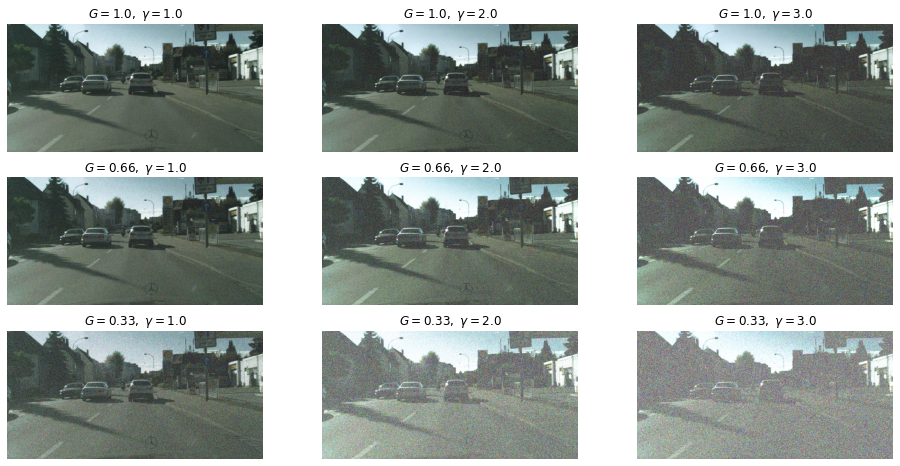

In [8]:
plt.figure(figsize=(16, 8))

index = 1
for i in gain:
    for j in gamma:
        sample['image'] = image.copy()
        
        cfg = get_cfg_defaults()
        cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                            'DATASET.DARKEN.GAIN', float(i),
                            'DATASET.DARKEN.GAMMA', float(j)])
        f = tr.Darken(cfg)
        processed_sample = f(sample)
        
        f = tr.UnDarken(cfg)
        processed_sample = f(processed_sample)
        
        plt.subplot(len(gain), len(gamma), index)
        plt.imshow(processed_sample['image'])
        plt.title("$G = {},~\gamma = {}$".format(i, j))
        plt.axis('off')
        index += 1

## Compute Histogram of Darkened Dataset

In [47]:
from tqdm import tqdm 

def sample_distribution(dataset, n=1000, channels=4):
    n = min(n, len(dataset))
    m = 100

    samples = np.zeros((m*n,channels))
    random_it = np.random.choice(len(dataset), n)
    for it, i in tqdm(enumerate(random_it)):
        img_path, depth_path, label_path = dataset.get_path(i)
        sample = dataset.loader.get_sample(img_path, depth_path, label_path)
        
        f = tr.Darken(cfg)
        sample = tr.ToTensor()(f(sample))
        
        if channels == 4 :
            sample['image'] = torch.cat((sample['image'], sample['depth'].unsqueeze(0)), 0)
        
        if isinstance(sample['image'], list):
            img = [np.asarray(img) for img in sample['image']]
            img = np.concatenate(img, axis=2)
        else:
            img = np.asarray(sample['image'])

        #Flatten image
        img = np.transpose(img, (1,2,0))
        img = np.reshape(img, (img.shape[0]*img.shape[1], img.shape[2]))
        if img.shape[0]>m:
            pixel_i = np.random.choice(img.shape[0], m)
            samples[it*m:(it+1)*m,:] = img[pixel_i, :]

    mean = np.mean(samples, axis=0)
    std = np.std(samples, axis=0)
    m_max = np.max(samples, axis=0)
    median = np.median(samples, axis=0)

    # if dataset.mode == "RGBD":
    #     import matplotlib.pyplot as plt
    #     plt.hist(samples[:, -1], bins='auto')
    #     plt.title("Depth histogram")
    #     plt.show()

    return {'mean': mean, 'std': std, 'max': m_max, 'median':median, 'samples': samples}

In [146]:
def get_dist(cfg_file, root):

    dist = {i: {j: dict() for j in gamma} for i in gain}

    for i in gain:
        for j in gamma:
            cfg = get_cfg_defaults()
            cfg.merge_from_file(cfg_file)
            cfg.merge_from_list(['DATASET.ROOT', root])
            cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                                'DATASET.DARKEN.GAIN', float(i),
                                'DATASET.DARKEN.GAMMA', float(j)])
            dataset = make_dataset(cfg, 'val')
            dist[i][j] = sample_distribution(dataset, 1000)
    return dist

In [147]:
def plot_dist(dist, dataset_name='Cityscapes'):
    fig = plt.figure(figsize=(5, 5))
    #plt.yscale('log')
    #plt.ylim([1, 10000])
    plt.xlim([0, 442])

    for i in gain:
        for j in gamma:
            n = dist[i][j]['samples'].shape[0]
            mag = np.sqrt(np.sum(np.power(dist[i][j]['samples'][:, :3], 2), axis=1))
            hist, bins = np.histogram(mag, bins=100, range=(0,442))
    #         x = np.linspace(0, 255, 100)
            bin_width = bins[1] - bins[0]
            x = np.array([x + bin_width/2.0 for x in bins[:-1]])

            hist = hist/n
            plt.plot(x, hist, label="$G = {},~\gamma = {}$".format(i, j))
    plt.title('{} RGB Histogram Under Different Darkening Treatments'.format(dataset_name))    
    plt.xlabel('Pixel Magnitude')
    plt.ylabel('Percentage of Pixels (Sample of {})'.format(len(dist[i][j]['samples'])))
    plt.legend()
    
    return fig

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


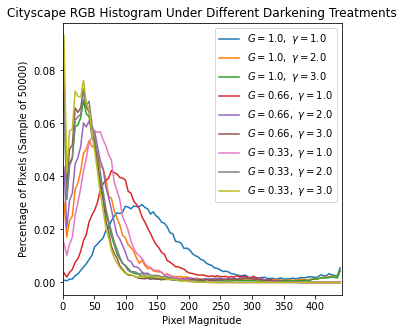

In [85]:
dist = get_dist('../configs/cityscapes_rgbd.yaml', '../datasets/cityscapes')
fig = plot_dist(dist, dataset_name='Cityscapes')
fig.savefig('figures/cityscapes_rgb_histogram_small.eps', format='eps')

In [ ]:
dist = get_dist('../configs/scenenet_rgbd.yaml', '../datasets/scenenet')
fig = plot_dist(dist, dataset_name='Scenenet')
fig.savefig('figures/scenenet_rgb_histogram_small.eps', format='eps')

## Network Performance

In [86]:
model_configs = model_utils.get_all_models("../run/")
len(model_configs)

91

In [87]:
low_light_models = [ \
                    #Bright models 
                   '../run/cityscapes/cityscapes_rgbd_xception_fine_coarse/2020_08_20-15_58_16/parameters.yaml',
                   '../run/cityscapes/cityscapes_rgb_xception_pt_fine_coarse/2020_08_03-15_41_22/parameters.yaml',
                    '../run/scenenet/scenenet_rgbd_xception/2020_09_17-22_10_19/parameters.yaml',
                   '../run/scenenet/scenenet_rgb_xception/2020_09_17-22_14_43/parameters.yaml',
                    #Low-light models
                   '../run/cityscapes/cityscapes_rgbd_xception_low_light/2020_09_25-19_32_43/parameters.yaml',
                   '../run/cityscapes/cityscapes_rgb_xception_low_light/2020_09_25-19_36_53/parameters.yaml',
                   '../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_25-23_11_51/parameters.yaml',
                   '../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_28-08_36_05/parameters.yaml']

In [148]:
failed = []

metric_dict = {'RGB': { 'low-light': { 'scenenet': {i: {j : 0 for j in gamma} for i in gain},
                                        'cityscapes': {i: {j : 0 for j in gamma} for i in gain}},
                        'normal': { 'scenenet': {i: {j : 0 for j in gamma} for i in gain},
                                        'cityscapes': {i: {j : 0 for j in gamma} for i in gain}}} ,
               'RGBD' : { 'low-light': { 'scenenet': {i: {j : 0 for j in gamma} for i in gain},
                                        'cityscapes': {i: {j : 0 for j in gamma} for i in gain}},
                        'normal': { 'scenenet': {i: {j : 0 for j in gamma} for i in gain},
                                        'cityscapes': {i: {j : 0 for j in gamma} for i in gain}}}}

for index, cfg_filepath in enumerate(low_light_models):
    try:
        print(cfg_filepath)
        cfg = model_utils.match_cfg_versions(cfg_filepath)
        cfg.merge_from_list(['CHECKPOINT.DIRECTORY', os.path.dirname(cfg_filepath),
                             'TEST.MAX_ITER', 1000,
                             'MODEL.PRETRAINED', "",
                             'SYSTEM.GPU_IDS', [0]]) #Since we're using saved models, pretrained weights will be overwritten anyway.

        for i in gain:
            for j in gamma:
                low = "low-light" if index>3 else "normal"
                
                cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                                    'DATASET.DARKEN.GAIN', float(i),
                                    'DATASET.DARKEN.GAMMA', float(j)])
        
                model_filepath = os.path.join(cfg.CHECKPOINT.DIRECTORY, cfg.CHECKPOINT.MODEL)
                checkpoint = torch.load(model_filepath, map_location=torch.device('cpu'))
                
                result_file = os.path.join(cfg.CHECKPOINT.DIRECTORY, 'validation_report_gain{:3.2f}_gamma{:3.2f}.txt'.format(float(i), float(j)))
                checkpoint_file = os.path.join(cfg.CHECKPOINT.DIRECTORY, 'checkpoint.pth.tar')
                if os.path.exists(result_file) and (os.path.getmtime(result_file) > os.path.getmtime(checkpoint_file)):
                    with open(result_file, 'r') as fp:
                        metric_str = fp.read().split('{')[1].split('}')[0].replace("'", '"')
                        metrics = json.loads('{' + metric_str + '}')
                else:
                    metrics = {'mIoU': 0}
                    print("Failed to load {}".format(result_file))
                    #metrics = model_utils.test_model(cfg, result_file)

                metric_dict[cfg.DATASET.MODE][low][cfg.DATASET.NAME][i][j] = metrics['mIoU']
        
    except Exception as e:
        print(e)
        print(cfg_filepath)
        failed.append(cfg_filepath)
        

../run/cityscapes/cityscapes_rgbd_xception_fine_coarse/2020_08_20-15_58_16/parameters.yaml
Non-existent key: DATASET.CITYSCAPES.TEST_SET
../run/cityscapes/cityscapes_rgb_xception_pt_fine_coarse/2020_08_03-15_41_22/parameters.yaml
../run/scenenet/scenenet_rgbd_xception/2020_09_17-22_10_19/parameters.yaml
Non-existent key: DATASET.CITYSCAPES.TEST_SET
../run/scenenet/scenenet_rgb_xception/2020_09_17-22_14_43/parameters.yaml
../run/cityscapes/cityscapes_rgbd_xception_low_light/2020_09_25-19_32_43/parameters.yaml
../run/cityscapes/cityscapes_rgb_xception_low_light/2020_09_25-19_36_53/parameters.yaml
../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_25-23_11_51/parameters.yaml
../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_28-08_36_05/parameters.yaml


In [134]:
from torchvision import transforms

def bar_plot(cfg, img_path, depth_path, label_path, dataset_name='cityscapes'):
    fig = plt.figure(figsize=(14, 12))
    
    index = 1
    for i in gain:
        for j in gamma:
            cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                                'DATASET.DARKEN.GAIN', float(i),
                                'DATASET.DARKEN.GAMMA', float(j)])
            dataset = make_dataset(cfg, 'val')
            sample = dataset.loader.load_sample(img_path, depth_path, label_path)
            sample['image'] = transforms.ToPILImage()(dataset.loader.invert_normalization(sample['image']))
            
            f = tr.UnDarken(cfg)
            sample = f(sample)

            plt.subplot(len(gain)*2, len(gamma)*2, index)
            plt.imshow(sample['image'])
            plt.title("$G = {},~\gamma = {}$ \n + Poisson Noise".format(i, j))
            plt.axis('off')
            index += 1

            labels = ['scenenet', 'cityscapes']

            y_pos = np.arange(2)
            width = 0.20

            ax1 = plt.subplot(len(gain)*2, len(gamma)*2, index)
            ax1.bar(-2*width, [metric_dict['RGB']['low-light'][dataset_name][i][j]],
                    width=width, color='midnightblue', label="rgb low-light")
            ax1.bar(-width, [metric_dict['RGBD']['low-light'][dataset_name][i][j]] ,
                    width=width, color='darkred', label="rgbd low-light")
            ax1.bar(0, [metric_dict['RGB']['normal'][dataset_name][i][j]],
                    width=width, color='blue', label="rgb")
            ax1.bar(width, [metric_dict['RGBD']['normal'][dataset_name][i][j]],
                    width=width, color='red', label="rgbd")

            plt.ylim((0, 0.7))
            ax1.get_xaxis().set_visible(False)

            for p in ax1.patches:
                if p.get_height() > 0 :
                    ax1.annotate("{:3.2}".format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

            index += 1

    ax1.legend()
    
    return figure

Using RGB input
Found 500 val images
Using RGB input
Found 500 val images
Using RGB input
Found 500 val images
Using RGB input
Found 500 val images
Using RGB input
Found 500 val images
Using RGB input
Found 500 val images
Using RGB input
Found 500 val images
Using RGB input
Found 500 val images
Using RGB input
Found 500 val images
Using RGB input
Found 500 val images


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


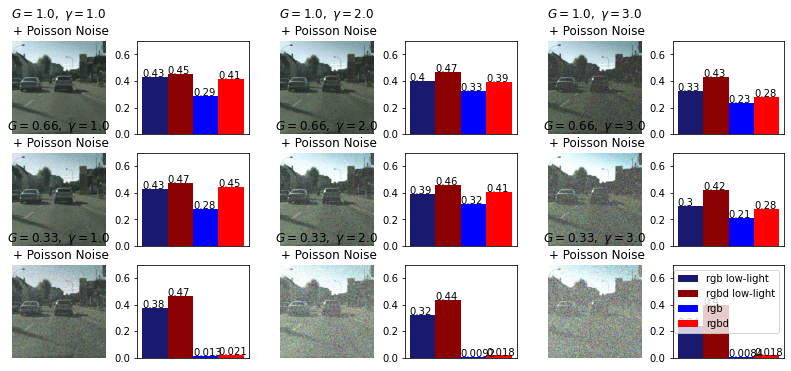

In [141]:
cfg = get_cfg_defaults()
cfg.merge_from_file('../configs/cityscapes_rgbd.yaml')
cfg.merge_from_list(['DATASET.ROOT', '../datasets/cityscapes/'])

dataset = make_dataset(cfg, 'val')
img_path, depth_path, label_path = dataset.get_path(2)
    
fig = bar_plot(cfg, img_path, depth_path, label_path, dataset_name='cityscapes')
fig.savefig('figures/cityscapes_dark_grid.eps', format='eps')

Using RGB input
Found 291919 val images
Using RGB input
Found 291919 val images
Using RGB input
Found 291919 val images
Using RGB input
Found 291919 val images
Using RGB input
Found 291919 val images
Using RGB input
Found 291919 val images
Using RGB input
Found 291919 val images
Using RGB input
Found 291919 val images
Using RGB input
Found 291919 val images
Using RGB input
Found 291919 val images


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


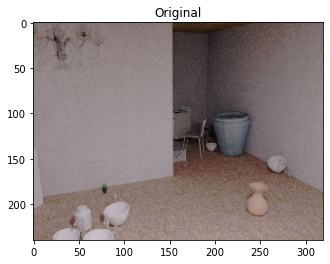

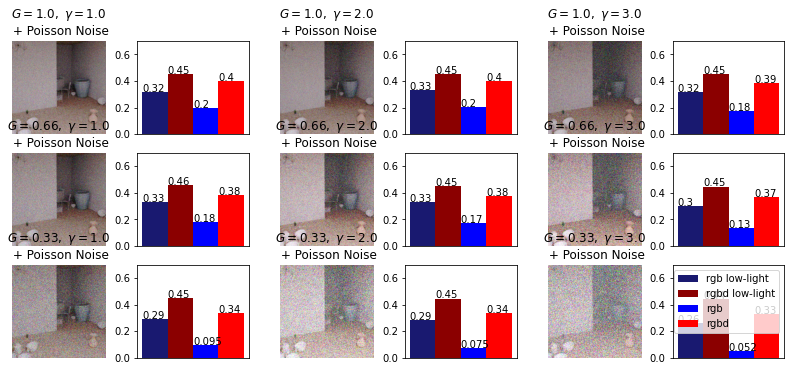

In [138]:
cfg = get_cfg_defaults()
cfg.merge_from_file('../configs/scenenet_rgbd.yaml')
cfg.merge_from_list(['DATASET.ROOT', '../datasets/scenenet/'])

dataset = make_dataset(cfg, 'val')
img_path, depth_path, label_path = dataset.get_path(175)
sample = dataset.loader.get_sample(img_path, depth_path, label_path)
image = sample['image']

plt.figure()
plt.imshow(image)
plt.title("Original") 
    
fig = bar_plot(cfg, img_path, depth_path, label_path, dataset_name='scenenet')
fig.savefig('figures/scenenet_dark_grid.eps', format='eps')

In [9]:
failed = []

metric_dict = {'RGB': { 'low-light': { 'scenenet': 0.0,
                                        'cityscapes': 0.0},
                        'normal': { 'scenenet': 0.0,
                                        'cityscapes': 0.0}} ,
               'RGBD' : { 'low-light': { 'scenenet': 0.0,
                                        'cityscapes': 0.0},
                        'normal': { 'scenenet': 0.0,
                                        'cityscapes': 0.0}}}

for index, cfg_filepath in enumerate(low_light_models):
    try:
        print(cfg_filepath)
        cfg = model_utils.match_cfg_versions(cfg_filepath)
        cfg.merge_from_list(['CHECKPOINT.DIRECTORY', os.path.dirname(cfg_filepath),
                             'TEST.MAX_ITER', 1000,
                             'MODEL.PRETRAINED', "",
                             'SYSTEM.GPU_IDS', [0]]) #Since we're using saved models, pretrained weights will be overwritten anyway.

        low = "low-light" if index>3 else "normal"

        cfg.merge_from_list(['DATASET.DARKEN.DARKEN', False])

        model_filepath = os.path.join(cfg.CHECKPOINT.DIRECTORY, cfg.CHECKPOINT.MODEL)
        checkpoint = torch.load(model_filepath, map_location=torch.device('cpu'))

        result_file = os.path.join(cfg.CHECKPOINT.DIRECTORY, 'validation_report.txt')
        checkpoint_file = os.path.join(cfg.CHECKPOINT.DIRECTORY, 'checkpoint.pth.tar')
        if os.path.exists(result_file) and (os.path.getmtime(result_file) > os.path.getmtime(checkpoint_file)):
            with open(result_file, 'r') as fp:
                metric_str = fp.read().split('{')[1].split('}')[0].replace("'", '"')
                metrics = json.loads('{' + metric_str + '}')
            print("Success on {} {} {} ".format(cfg.DATASET.MODE, low, cfg.DATASET.NAME))
        else:
            metrics = {'mIoU': 0}
            print("Failed to load {}".format(result_file))
            #metrics = model_utils.test_model(cfg, result_file)

        metric_dict[cfg.DATASET.MODE][low][cfg.DATASET.NAME] = metrics['mIoU']
        
    except Exception as e:
        print(e)
        print(cfg_filepath)
        failed.append(cfg_filepath)

../run/cityscapes/cityscapes_rgbd_xception_fine_coarse/2020_08_20-15_58_16/parameters.yaml
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Success on RGBD normal cityscapes 
../run/cityscapes/cityscapes_rgb_xception_pt_fine_coarse/2020_08_03-15_41_22/parameters.yaml


/home/cecilia/pytorch-deeplab-xception/deeplab3/utils/model_utils.py:39: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  model_cfg = yaml.load(f)


Success on RGB normal cityscapes 
../run/scenenet/scenenet_rgbd_xception/2020_09_17-22_10_19/parameters.yaml
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Success on RGBD normal scenenet 
../run/scenenet/scenenet_rgb_xception/2020_09_17-22_14_43/parameters.yaml
Success on RGB normal scenenet 
../run/cityscapes/cityscapes_rgbd_xception_low_light/2020_09_25-19_32_43/parameters.yaml
Success on RGBD low-light cityscapes 
../run/cityscapes/cityscapes_rgb_xception_low_light/2020_09_25-19_36_53/parameters.yaml
Success on RGB low-light cityscapes 
../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_25-23_11_51/parameters.yaml
Success on RGBD low-light scenenet 
../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_28-08_36_05/parameters.yaml
Success on RGB low-light scenenet 


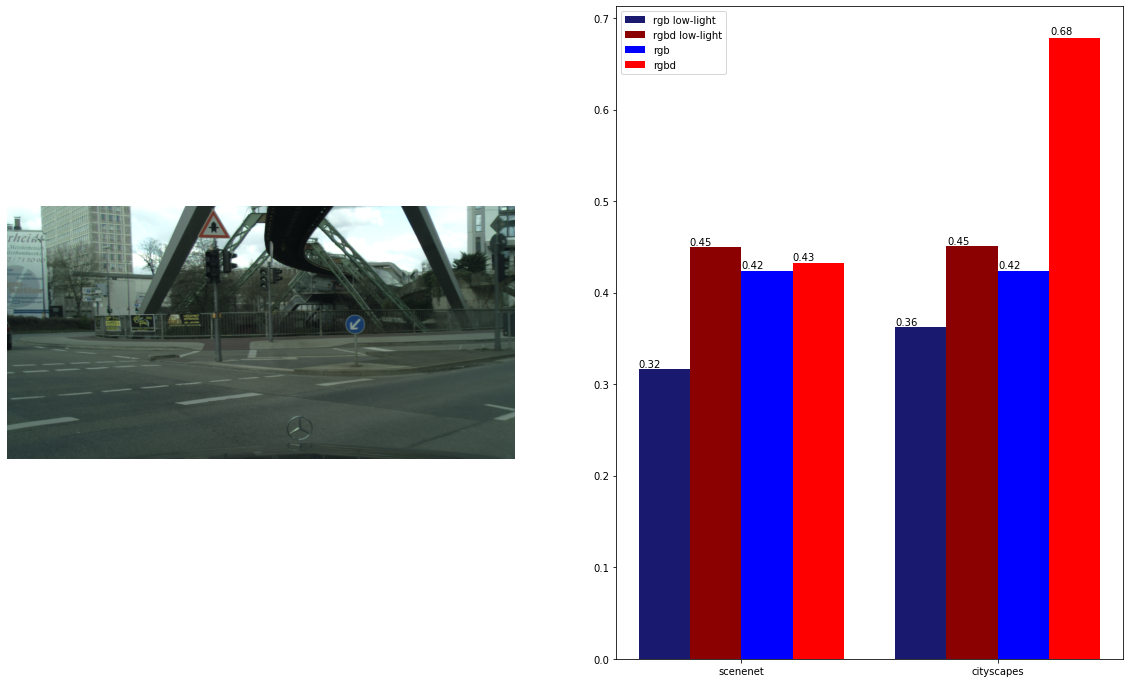

In [12]:
plt.figure(figsize=(20, 12))

index = 1
sample['image'] = image.copy()

cfg = get_cfg_defaults()
cfg.merge_from_list(['DATASET.DARKEN.DARKEN', False])
#         f = tr.Darken(cfg)
#         processed_sample = f(sample)
        
#         f = tr.UnDarken(cfg)
#         processed_sample = f(processed_sample)
        
plt.subplot(1, 2, 1)
plt.imshow(sample['image'])
#         plt.title("Gain = {}, Gamma = {}".format(i, j))
plt.axis('off')
index += 1

labels = ['scenenet', 'cityscapes']

y_pos = np.arange(2)
width = 0.20

ax1 = plt.subplot(1, 2, 2)
ax1.bar(y_pos - 2*width, [metric_dict['RGB']['low-light']['scenenet'], 
                         metric_dict['RGB']['low-light']['cityscapes']], 
        width=width, color='midnightblue', label="rgb low-light")
ax1.bar(y_pos - width, [metric_dict['RGBD']['low-light']['scenenet'], 
                        metric_dict['RGBD']['low-light']['cityscapes']], 
        width=width, color='darkred', label="rgbd low-light")
ax1.bar(y_pos, [metric_dict['RGB']['normal']['scenenet'], 
                metric_dict['RGB']['normal']['scenenet']], 
        width=width, color='blue', label="rgb")
ax1.bar(y_pos + width, [metric_dict['RGBD']['normal']['scenenet'], 
                        metric_dict['RGBD']['normal']['cityscapes']],
        width=width, color='red', label="rgbd")

ax1.set_xticks(y_pos - 0.1)
ax1.set_xticklabels(labels)

for p in ax1.patches:
    if p.get_height() > 0 :
        ax1.annotate("{:3.2}".format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

index += 1
        
ax1.legend()
plt.ylim((0, 0.7))

In [144]:
def make_bar_plot(ax1, low_light_models, report_name = 'validation_report.txt'):
    failed = []
    labels = ['scenenet', 'cityscapes']
    
    metric_dict = {'RGB': { 'low-light': { 'scenenet': 0.0,
                                            'cityscapes': 0.0},
                            'normal': { 'scenenet': 0.0,
                                            'cityscapes': 0.0}} ,
                   'RGBD' : { 'low-light': { 'scenenet': 0.0,
                                            'cityscapes': 0.0},
                            'normal': { 'scenenet': 0.0,
                                            'cityscapes': 0.0}}}

    for index, cfg_filepath in enumerate(low_light_models):
        try:
            print(cfg_filepath)
            cfg = model_utils.match_cfg_versions(cfg_filepath)
            cfg.merge_from_list(['CHECKPOINT.DIRECTORY', os.path.dirname(cfg_filepath),
                                 'TEST.MAX_ITER', 1000,
                                 'MODEL.PRETRAINED', "",
                                 'SYSTEM.GPU_IDS', [0]]) #Since we're using saved models, pretrained weights will be overwritten anyway.

            low = "low-light" if index>3 else "normal"

            cfg.merge_from_list(['DATASET.DARKEN.DARKEN', False])

            model_filepath = os.path.join(cfg.CHECKPOINT.DIRECTORY, cfg.CHECKPOINT.MODEL)
            checkpoint = torch.load(model_filepath, map_location=torch.device('cpu'))

            result_file = os.path.join(cfg.CHECKPOINT.DIRECTORY, report_name)
            if os.path.exists(result_file):
                with open(result_file, 'r') as fp:
                    metric_str = fp.read().split('{')[1].split('}')[0].replace("'", '"')
                    metrics = json.loads('{' + metric_str + '}')
                print("Success on {} {} {} ".format(cfg.DATASET.MODE, low, cfg.DATASET.NAME))
            else:
                metrics = {'mIoU': 0}
                print("Failed to load {}".format(result_file))
                #metrics = model_utils.test_model(cfg, result_file)

            metric_dict[cfg.DATASET.MODE][low][cfg.DATASET.NAME] = metrics['mIoU']

        except Exception as e:
            print(e)
            print(cfg_filepath)
            failed.append(cfg_filepath)

    y_pos = np.arange(2)
    width = 0.20

    ax1.bar(y_pos - 2*width, [metric_dict['RGB']['low-light']['scenenet'], 
                             metric_dict['RGB']['low-light']['cityscapes']], 
            width=width, color='midnightblue', label="rgb low-light")
    ax1.bar(y_pos - width, [metric_dict['RGBD']['low-light']['scenenet'], 
                            metric_dict['RGBD']['low-light']['cityscapes']], 
            width=width, color='darkred', label="rgbd low-light")
    ax1.bar(y_pos, [metric_dict['RGB']['normal']['scenenet'], 
                    metric_dict['RGB']['normal']['scenenet']], 
            width=width, color='blue', label="rgb")
    ax1.bar(y_pos + width, [metric_dict['RGBD']['normal']['scenenet'], 
                            metric_dict['RGBD']['normal']['cityscapes']],
            width=width, color='red', label="rgbd")

    ax1.set_xticks(y_pos - 0.1)
    ax1.set_xticklabels(labels)
    plt.ylim((0, 0.7))

    for p in ax1.patches:
        if p.get_height() > 0 :
            ax1.annotate("{:3.2}".format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

    return failed

Using RGB-D input
Found 500 val images
../run/cityscapes/cityscapes_rgbd_xception_fine_coarse/2020_08_20-15_58_16/parameters.yaml
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Success on RGBD normal cityscapes 
../run/cityscapes/cityscapes_rgb_xception_pt_fine_coarse/2020_08_03-15_41_22/parameters.yaml
Success on RGB normal cityscapes 
../run/scenenet/scenenet_rgbd_xception/2020_09_17-22_10_19/parameters.yaml
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Success on RGBD normal scenenet 
../run/scenenet/scenenet_rgb_xception/2020_09_17-22_14_43/parameters.yaml
Success on RGB normal scenenet 
../run/cityscapes/cityscapes_rgbd_xception_low_light/2020_09_25-19_32_43/parameters.yaml
Success on RGBD low-light cityscapes 
../run/cityscapes/cityscapes_rgb_xception_low_light/2020_09_25-19_36_53/parameters.yaml
Success on RGB low-light cityscapes 
../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_25-23_11_51/parameters.yaml
Success on RGBD low-light scenenet 
../run/scenenet/scenenet_rgbd

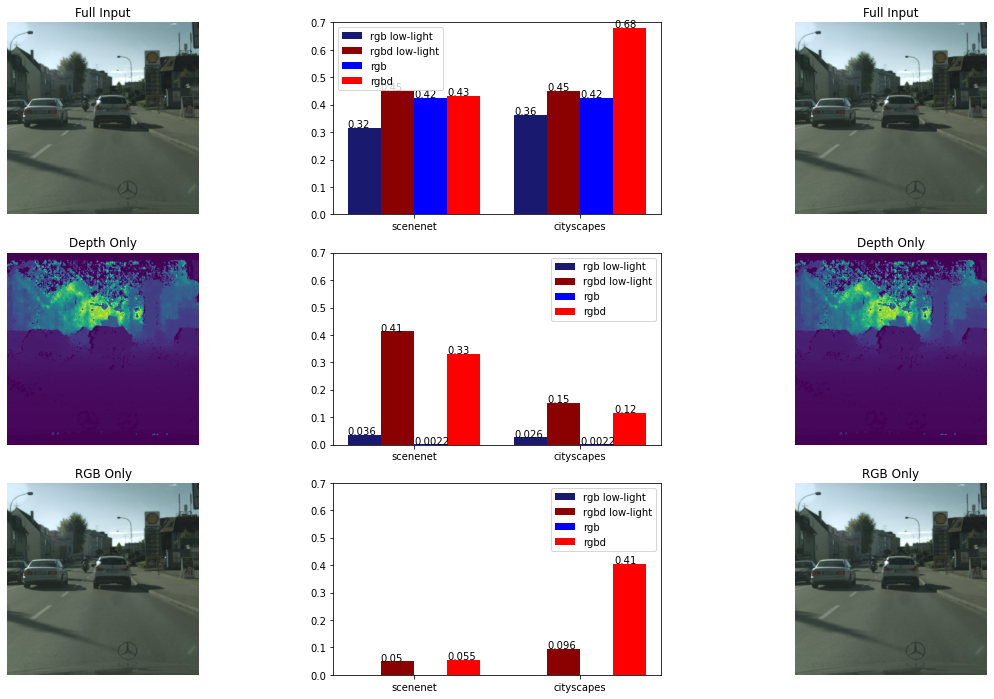

In [153]:
plt.figure(figsize=(20, 12))

cfg = get_cfg_defaults()
cfg.merge_from_file('../configs/cityscapes_rgbd.yaml')
cfg.merge_from_list(['DATASET.ROOT', '../datasets/cityscapes/'])

dataset = make_dataset(cfg, 'val')
sample = dataset.loader.load_sample(img_path, depth_path, label_path)
sample['image'] = dataset.loader.invert_normalization(sample['image'])
 
plt.subplot(3, 3, 1)
plt.title("Full Input")
plt.imshow(sample['image'][:, :, :3])
plt.axis('off')

ax1 = plt.subplot(3, 3, 2)
make_bar_plot(ax1, low_light_models, report_name = 'validation_report.txt')
        
ax1.legend()

plt.subplot(3, 3, 3)
plt.title("Full Input")
plt.imshow(sample['image'][:, :, :3])
plt.axis('off')

plt.subplot(3, 3, 4)
plt.title("Depth Only")
plt.imshow(sample['image'][:, :, 3:])
plt.axis('off')

ax1 = plt.subplot(3, 3, 5)
make_bar_plot(ax1, low_light_models, report_name = 'validation_report_depth_only.txt')
    
ax1.legend()

plt.subplot(3, 3, 6)
plt.title("Depth Only")
plt.imshow(sample['image'][:, :, 3:])
plt.axis('off')

plt.subplot(3, 3, 7)
plt.title("RGB Only")
plt.imshow(sample['image'][:, :, :3])
plt.axis('off')

ax1 = plt.subplot(3, 3, 8)
make_bar_plot(ax1, low_light_models, report_name = 'validation_report_no_depth.txt')

plt.subplot(3, 3, 9)
plt.title("RGB Only")
plt.imshow(sample['image'][:, :, :3])
plt.axis('off')
        
ax1.legend()